# Hierarchical Classification - Stage 2: Bare Metal Training (Stage 2 Only)

This notebook trains **only Stage 2 (Fine Classifiers) from scratch**.

## Training Pipeline
- **Bare Metal**: No pre-trained weights are loaded for Stage 1. All components are initialized randomly.
- **Stage 2 Only**: The optimization setup focuses EXCLUSIVELY on the fine classification loss.
- **No Freezing**: All parameters are technically trainable, but the loss function is derived entirely from the fine classifiers.

## Datasets
Merged 3D MedMNIST datasets (Organ, Nodule, Adrenal, Fracture, Vessel).

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import time

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Merged Dataset

In [2]:
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")
train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Coarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

## 2. Build Hierarchical Model (Random Initialization)

In [3]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("\nBuilding Hierarchical Model (Bare Metal - Random Weights)...")
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Note: We specifically SKIP loading stage1 weights here.

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Building Hierarchical Model (Bare Metal - Random Weights)...
Model created:
  Total parameters: 8,375,191
  Trainable parameters: 8,375,191


## 3. Training Loop (Stage 2 Only)

In [4]:
def train_bare_metal_fine_only(model, train_loader, val_loader, device, epochs, lr, region_idx_to_name):
    """
    Train ONLY Stage 2 (Fine Classifiers) from scratch.
    Loss is computed only based on fine predictions.
    """
    
    # Combined optimizer for all parameters (no freezes, just no coarse loss)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Loss functions
    fine_criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [], 'val_loss': [],
        'fine_train_acc': [], 'fine_val_acc': [],
        'fine_val_acc_per_region': {}
    }
    
    best_val_fine_acc = 0.0
    
    print("\nStarting Bare Metal Training (Stage 2 Fine Only)...")
    
    # Set model architecture name for saving
    save_name = f"hierarchical_model_{MODEL_CONFIG['architecture']}_bare_metal.pth"
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Fine metrics
        f_correct = 0
        f_total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for imgs, coarse_labels, fine_labels in pbar:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1: imgs = imgs / 255.0
            
            coarse_labels = coarse_labels.long().to(device)
            fine_labels = fine_labels.long().to(device)
            
            optimizer.zero_grad()
            
            # --- Forward Pass ---
            # fine only
            loss_fine = 0.0
            fine_batch_correct = 0
            fine_batch_total = 0
            
            # Ground Truth Routing for training
            for region_idx, region_name in region_idx_to_name.items():
                mask = (coarse_labels == region_idx)
                if mask.sum() > 0:
                    region_imgs = imgs[mask]
                    region_fine_labels = fine_labels[mask]
                    
                    fine_logits = model.forward_fine(region_imgs, region_name)
                    loss_fine += fine_criterion(fine_logits, region_fine_labels)
                    
                    fine_preds = fine_logits.argmax(1)
                    fine_batch_correct += (fine_preds == region_fine_labels).sum().item()
                    fine_batch_total += region_imgs.size(0)
            
            # Only backward fine loss
            if isinstance(loss_fine, torch.Tensor):
                loss_fine.backward()
                optimizer.step()
                train_loss += loss_fine.item()
            
            # Track metrics
            f_correct += fine_batch_correct
            f_total += fine_batch_total
            
            loss_val = loss_fine.item() if isinstance(loss_fine, torch.Tensor) else 0.0
            pbar.set_postfix({'loss': f"{loss_val:.2f}"})
        
        # Epoch Summary
        avg_train_loss = train_loss / len(train_loader)
        train_fine_acc = f_correct / f_total if f_total else 0
        
        history['train_loss'].append(avg_train_loss)
        history['fine_train_acc'].append(train_fine_acc)
        
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_f_correct = 0
        val_f_total = 0
        
        with torch.no_grad():
            for imgs, coarse_labels, fine_labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1: imgs = imgs / 255.0
                
                coarse_labels = coarse_labels.long().to(device)
                fine_labels = fine_labels.long().to(device)
                
                loss_f = 0.0
                # Validation on Ground Truth routing
                for region_idx, region_name in region_idx_to_name.items():
                    mask = (coarse_labels == region_idx)
                    if mask.sum() > 0:
                        region_imgs = imgs[mask]
                        region_fine_labels = fine_labels[mask]
                        
                        fine_logits = model.forward_fine(region_imgs, region_name)
                        loss_f += fine_criterion(fine_logits, region_fine_labels)
                        
                        fine_preds = fine_logits.argmax(1)
                        hits = (fine_preds == region_fine_labels).sum().item()
                        val_f_correct += hits
                        val_f_total += region_imgs.size(0)
                
                val_loss += loss_f.item() if isinstance(loss_f, torch.Tensor) else 0.0

        avg_val_loss = val_loss / len(val_loader)
        val_fine_acc = val_f_correct / val_f_total if val_f_total else 0
        
        history['val_loss'].append(avg_val_loss)
        history['fine_val_acc'].append(val_fine_acc)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Fine Acc={train_fine_acc:.4f}")
        print(f"  Val: Loss={avg_val_loss:.4f}, Fine Acc={val_fine_acc:.4f}")
        
        # Save Best Model
        if val_fine_acc > best_val_fine_acc:
            best_val_fine_acc = val_fine_acc
            save_path = f"{PATHS['models']}/{save_name}"
            torch.save(model.state_dict(), save_path)
            print(f"  -> New best model saved: {save_path} (Acc: {best_val_fine_acc:.4f})")

    return history

In [5]:
# Run Training
print(f"Training Configuration:")
print(f"  Epochs: {TRAINING_CONFIG['fine_epochs']}")
print(f"  Learning Rate: {TRAINING_CONFIG['learning_rate']}")

history = train_bare_metal_fine_only(
    model, train_loader, val_loader, DEVICE,
    epochs=TRAINING_CONFIG['fine_epochs'],
    lr=TRAINING_CONFIG['learning_rate'],
    region_idx_to_name=region_idx_to_name
)

Training Configuration:
  Epochs: 30
  Learning Rate: 0.001


/home/luca/.pyenv/versions/3.12.11/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting Bare Metal Training (Stage 2 Fine Only)...


Epoch 1/30: 100%|██████████| 710/710 [00:32<00:00, 21.95it/s, loss=3.01]


Epoch 1: Loss=2.9100, Fine Acc=0.5857
  Val: Loss=1.7755, Fine Acc=0.5627
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.5627)


Epoch 2/30: 100%|██████████| 710/710 [00:32<00:00, 22.00it/s, loss=2.39]


Epoch 2: Loss=2.5589, Fine Acc=0.6117
  Val: Loss=1.4536, Fine Acc=0.5947
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.5947)


Epoch 3/30: 100%|██████████| 710/710 [00:31<00:00, 22.31it/s, loss=2.65]


Epoch 3: Loss=2.4273, Fine Acc=0.6306
  Val: Loss=1.7901, Fine Acc=0.5125


Epoch 4/30: 100%|██████████| 710/710 [00:31<00:00, 22.36it/s, loss=1.58]


Epoch 4: Loss=2.2714, Fine Acc=0.6469
  Val: Loss=2.3348, Fine Acc=0.5724


Epoch 5/30: 100%|██████████| 710/710 [00:32<00:00, 22.08it/s, loss=1.12]


Epoch 5: Loss=2.2522, Fine Acc=0.6533
  Val: Loss=1.2653, Fine Acc=0.5933


Epoch 6/30: 100%|██████████| 710/710 [00:32<00:00, 21.89it/s, loss=1.26]


Epoch 6: Loss=2.1490, Fine Acc=0.6624
  Val: Loss=1.1209, Fine Acc=0.6797
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.6797)


Epoch 7/30: 100%|██████████| 710/710 [00:34<00:00, 20.80it/s, loss=5.49]


Epoch 7: Loss=2.1511, Fine Acc=0.6612
  Val: Loss=1.4219, Fine Acc=0.5404


Epoch 8/30: 100%|██████████| 710/710 [00:32<00:00, 22.18it/s, loss=1.53]


Epoch 8: Loss=2.0961, Fine Acc=0.6723
  Val: Loss=1.3662, Fine Acc=0.6769


Epoch 9/30: 100%|██████████| 710/710 [00:32<00:00, 22.12it/s, loss=2.84]


Epoch 9: Loss=2.0702, Fine Acc=0.6712
  Val: Loss=0.9775, Fine Acc=0.6825
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.6825)


Epoch 10/30: 100%|██████████| 710/710 [00:33<00:00, 21.37it/s, loss=1.91]


Epoch 10: Loss=2.0526, Fine Acc=0.6684
  Val: Loss=0.9623, Fine Acc=0.6922
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.6922)


Epoch 11/30: 100%|██████████| 710/710 [00:32<00:00, 21.80it/s, loss=1.49]


Epoch 11: Loss=2.0233, Fine Acc=0.6881
  Val: Loss=0.8090, Fine Acc=0.7270
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7270)


Epoch 12/30: 100%|██████████| 710/710 [00:32<00:00, 21.79it/s, loss=3.46]


Epoch 12: Loss=1.9583, Fine Acc=0.6906
  Val: Loss=0.7784, Fine Acc=0.7228


Epoch 13/30: 100%|██████████| 710/710 [00:32<00:00, 22.02it/s, loss=1.46]


Epoch 13: Loss=1.9035, Fine Acc=0.7012
  Val: Loss=0.7901, Fine Acc=0.7465
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7465)


Epoch 14/30: 100%|██████████| 710/710 [00:32<00:00, 22.17it/s, loss=0.67]


Epoch 14: Loss=1.8467, Fine Acc=0.7021
  Val: Loss=0.7340, Fine Acc=0.7604
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7604)


Epoch 15/30: 100%|██████████| 710/710 [00:32<00:00, 22.10it/s, loss=1.69]


Epoch 15: Loss=1.8693, Fine Acc=0.7086
  Val: Loss=0.7232, Fine Acc=0.7465


Epoch 16/30: 100%|██████████| 710/710 [00:31<00:00, 22.32it/s, loss=1.44]


Epoch 16: Loss=1.8169, Fine Acc=0.7107
  Val: Loss=0.7619, Fine Acc=0.7368


Epoch 17/30: 100%|██████████| 710/710 [00:34<00:00, 20.43it/s, loss=0.92]


Epoch 17: Loss=1.7939, Fine Acc=0.7121
  Val: Loss=0.6789, Fine Acc=0.7507


Epoch 18/30: 100%|██████████| 710/710 [00:33<00:00, 20.98it/s, loss=5.78]


Epoch 18: Loss=1.7415, Fine Acc=0.7258
  Val: Loss=0.7344, Fine Acc=0.7563


Epoch 19/30: 100%|██████████| 710/710 [00:33<00:00, 21.03it/s, loss=1.00]


Epoch 19: Loss=1.6853, Fine Acc=0.7320
  Val: Loss=0.7106, Fine Acc=0.7479


Epoch 20/30: 100%|██████████| 710/710 [00:34<00:00, 20.84it/s, loss=1.66]


Epoch 20: Loss=1.6900, Fine Acc=0.7313
  Val: Loss=0.6608, Fine Acc=0.7604


Epoch 21/30: 100%|██████████| 710/710 [00:33<00:00, 21.05it/s, loss=0.98]


Epoch 21: Loss=1.6751, Fine Acc=0.7350
  Val: Loss=0.8385, Fine Acc=0.6964


Epoch 22/30: 100%|██████████| 710/710 [00:33<00:00, 20.89it/s, loss=1.54]


Epoch 22: Loss=1.6484, Fine Acc=0.7309
  Val: Loss=0.6291, Fine Acc=0.7772
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7772)


Epoch 23/30: 100%|██████████| 710/710 [00:34<00:00, 20.84it/s, loss=0.84]


Epoch 23: Loss=1.5728, Fine Acc=0.7434
  Val: Loss=0.6316, Fine Acc=0.7786
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7786)


Epoch 24/30: 100%|██████████| 710/710 [00:33<00:00, 21.01it/s, loss=1.72]


Epoch 24: Loss=1.5602, Fine Acc=0.7517
  Val: Loss=0.5628, Fine Acc=0.7799
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7799)


Epoch 25/30: 100%|██████████| 710/710 [00:33<00:00, 21.05it/s, loss=0.82]


Epoch 25: Loss=1.5223, Fine Acc=0.7547
  Val: Loss=0.6690, Fine Acc=0.7716


Epoch 26/30: 100%|██████████| 710/710 [00:33<00:00, 21.00it/s, loss=0.97]


Epoch 26: Loss=1.5239, Fine Acc=0.7515
  Val: Loss=0.5824, Fine Acc=0.7855
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7855)


Epoch 27/30: 100%|██████████| 710/710 [00:33<00:00, 20.95it/s, loss=1.30]


Epoch 27: Loss=1.4709, Fine Acc=0.7586
  Val: Loss=0.6307, Fine Acc=0.7813


Epoch 28/30: 100%|██████████| 710/710 [00:33<00:00, 21.35it/s, loss=2.56]


Epoch 28: Loss=1.4507, Fine Acc=0.7579
  Val: Loss=0.7175, Fine Acc=0.7591


Epoch 29/30: 100%|██████████| 710/710 [00:33<00:00, 21.14it/s, loss=0.99]


Epoch 29: Loss=1.4099, Fine Acc=0.7683
  Val: Loss=0.5503, Fine Acc=0.7967
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.7967)


Epoch 30/30: 100%|██████████| 710/710 [00:33<00:00, 21.22it/s, loss=0.68]


Epoch 30: Loss=1.3656, Fine Acc=0.7700
  Val: Loss=0.5613, Fine Acc=0.8008
  -> New best model saved: /home/luca/HierarchicalMIC/models/hierarchical_model_enhanced_bare_metal.pth (Acc: 0.8008)


## 4. Visualization

Figure saved to /home/luca/HierarchicalMIC/figures/bare_metal_training_enhanced.png


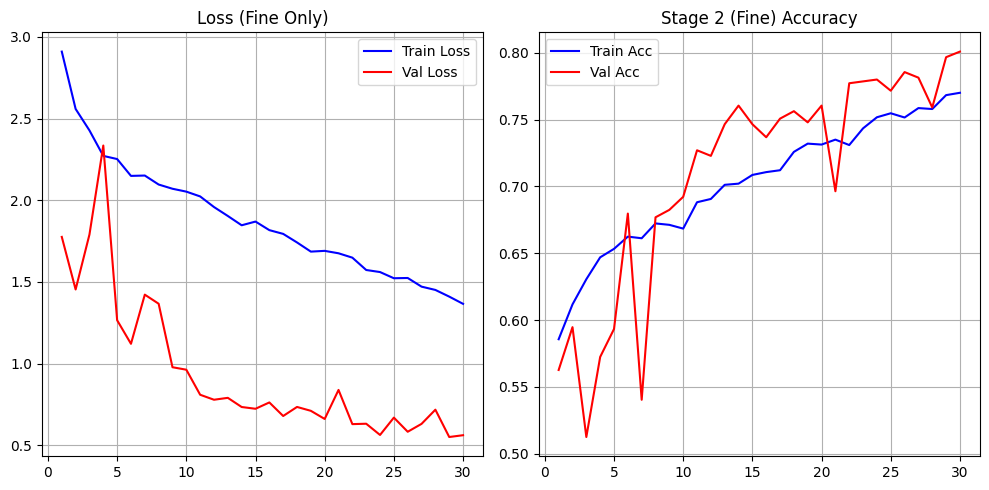

In [6]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss (Fine Only)')
    plt.legend()
    plt.grid(True)
    
    # Fine Acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['fine_train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['fine_val_acc'], 'r-', label='Val Acc')
    plt.title('Stage 2 (Fine) Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{PATHS['figures']}/bare_metal_training_{MODEL_CONFIG['architecture']}.png")
    print(f"Figure saved to {PATHS['figures']}/bare_metal_training_{MODEL_CONFIG['architecture']}.png")
    plt.show()

plot_history(history)